<a href="https://colab.research.google.com/github/see-3pO/Learning_Tensorflow/blob/master/Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# importing libs
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# loading the data
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split = ['train', 'test'],
    shuffle_files = True,
    as_supervised = True,
    with_info = True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.TR80C2_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.TR80C2_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [5]:
print(ds_info)

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir=PosixGPath('/tmp/tmp8jf4cthitfds'),
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning mult

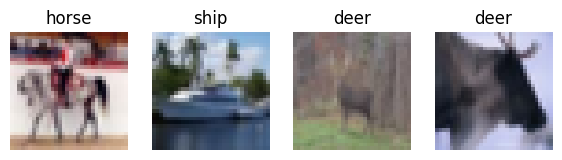

In [6]:
# data analysis
# displaying four random images with labels from the training set

get_label_name = ds_info.features['label'].int2str
train_iter = iter(ds_train)
fig = plt.figure(figsize=(7, 8))
for x in range(4):
  image, label = next(train_iter)
  fig.add_subplot(1, 4, x+1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(get_label_name(label))

In [7]:
# function to normalize images
def normalize_image(image, label):
  """normalizes images"""
  return tf.cast(image, tf.float32)/255.0, label

In [8]:
# parameter declaration
autotune = tf.data.experimental.AUTOTUNE
batch_size = 32

Data Augmentation using `tf.image` module

In [9]:
# augmentation function
def augment(image, label):
  new_height = new_width = 32
  image =tf.image.resize(image, (new_height, new_width))

  if tf.random.uniform((), minval=0, maxval=1) < 0.1:
    image = tf.tile(tf.image.rgb_to_grayscale(image), [1, 1, 3])

  image = tf.image.random_brightness(image, max_delta=0.1)
  image = tf.image.random_contrast(image, lower=0.1, upper=0.2)
  image = tf.image.random_flip_left_right(image) # 50% of images

  return image, label



In [10]:
# train dataset setup
ds_train = ds_train.map(normalize_image, num_parallel_calls=autotune)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.map(augment, num_parallel_calls=autotune)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(autotune)

In [11]:
# test dataset setup
ds_test = ds_test.map(normalize_image, num_parallel_calls=autotune)
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.prefetch(autotune)

In [12]:
# create sequential model
model = keras.Sequential(
    [
        keras.Input((32, 32, 3)),
        layers.Conv2D(4, 3, padding='same', activation='relu'),
        layers.Conv2D(8, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10),
    ]
)

In [13]:
# compile the code
model.compile(
    optimizer = keras.optimizers.Adam(3e-4),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [14]:
# fit the model
model.fit(ds_train, epochs=5, verbose=2)

# evaluate the model
model.evaluate(ds_test)

Epoch 1/5
1563/1563 - 70s - loss: 2.0917 - accuracy: 0.2080 - 70s/epoch - 45ms/step
Epoch 2/5
1563/1563 - 47s - loss: 1.9565 - accuracy: 0.2759 - 47s/epoch - 30ms/step
Epoch 3/5
1563/1563 - 50s - loss: 1.8645 - accuracy: 0.3213 - 50s/epoch - 32ms/step
Epoch 4/5
1563/1563 - 59s - loss: 1.7916 - accuracy: 0.3506 - 59s/epoch - 38ms/step
Epoch 5/5
1563/1563 - 63s - loss: 1.7322 - accuracy: 0.3736 - 63s/epoch - 40ms/step
313/313 [==============================] - 7s 20ms/step - loss: 3.2557 - accuracy: 0.2951


[3.2556562423706055, 0.29510000348091125]

Data Augmentation with Keras Sequential

In [ ]:
# data augmentation with keras sequential
data_augmentation = keras.Sequential(
    [
        layers.Resizing(height=32, width=32),
        layers.RandomFlip(mode="horizontal"),
        layers.RandomContrast(factor=0.1)

    ]
)

In [ ]:
# create sequential model
model_two = keras.Sequential(
    [
        keras.Input((32, 32, 3)),
        data_augmentation,
        layers.Conv2D(4, 3, padding='same', activation='relu'),
        layers.Conv2D(8, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10),
    ]
)
